In [61]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
device = torch.device('cuda') if (USE_GPU and torch.cuda.is_available()) else torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100
print('using device:', device)

using device: cpu


In [3]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  FOLDERNAME = '/HACKATHON'
  %cd /content/gdrive/My\ Drive/$FOLDERNAME
except ImportError:
  pass

In [4]:
%pwd

'/Users/emilienprn/Documents/2A/HACKATON_ELEVEN'

In [45]:
df_train = pd.read_csv('processed_waiting_times_train.csv')

In [46]:
out_features = max(df_train["WAIT_TIME_IN_2H"]) + 1
print(f"out_features: {out_features}")

y = df_train["WAIT_TIME_IN_2H"]
#print(y)

x = df_train
x.drop(["WAIT_TIME_IN_2H"], axis=1, inplace=True)
#print(x)

in_features = len(x.columns)
print(f"in_features: {in_features}")

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

x_train = x_train.astype(float)
x_test = x_test.astype(float)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

x_train = torch.tensor(x_train.values, dtype=torch.float64, device=device)
x_test = torch.tensor(x_test.values, dtype=torch.float64, device=device)
y_train = torch.tensor(y_train.values, dtype=torch.int64, device=device)
y_test = torch.tensor(y_test.values, dtype=torch.int64, device=device)

out_features: 32
in_features: 87


In [47]:
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [48]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

utils

In [7]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            y_res = model(x)
            predictions = F.softmax(y_res, dim=1)
            argmax_indices = torch.argmax(predictions, dim=1)

            num_correct += torch.sum(torch.eq(argmax_indices, y))
            num_samples += int(y_res.size()[0])

        acc = float(num_correct) / num_samples
        #print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

        return acc

def check_rmse(x_test, y_test, model):
    model.eval()
    x_test = x_test.to(device=device, dtype=torch.float)
    y_hat = torch.argmax(model(x_test), dim=1)
    rmse = torch.sqrt(torch.sum((y_hat * 5 - y_test * 5)**2) / len(y_hat))
    return float(rmse)

def check_rmse_numeric(x_test, y_test, model):
    model.eval()
    x_test = x_test.to(device=device, dtype=torch.float)
    y_hat = model(x_test)
    rmse = torch.sqrt(torch.sum((y_hat * 5 - y_test * 5)**2) / len(y_hat))
    return float(rmse)

In [49]:
def train_module(model, optimizer, criterion, x_train, y_train, rmse_function, epochs=1, batch_size=64, rmse_on_test = False, x_test=None, y_test=None):
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    losses = []
    rmses = []
    rmses_test = []

    model = model.to(device=device)
    model.train()
    for e in range(epochs):
        for inputs, targets in train_loader:
            inputs = inputs.to(device=device, dtype=torch.float)
            outputs = model(inputs)

            #outputs = outputs.squeeze(1)

            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

        losses.append(loss.item())
        current_rmse      = rmse_function(x_train, y_train, model)
        current_rmse_test = rmse_function(x_test, y_test, model)

        rmses.append(current_rmse)
        rmses_test.append(current_rmse_test)

        print(f'Epoch [{e+1}/{epochs}] -  Loss: {loss.item():.4f} - Rmse: {current_rmse:.4f}')
        if(rmse_on_test): print(f'\t \t \t  test rmse: {current_rmse_test:.4f}')

    return losses, rmses, rmses_test

training

In [98]:
class Swish(nn.Module):
  def forward(self, x):
    return x*torch.sigmoid(x)

In [99]:
class CombinedLoss(nn.Module):
    def __init__(self, mse_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.mse_weight = mse_weight

        self.mse_loss           = nn.MSELoss()
        self.cross_entropy_loss = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        mse_loss = self.mse_loss(torch.argmax(outputs), targets.float()) / 100000
        cross_entropy_loss = self.cross_entropy_loss(outputs, targets) / 2

        combined_loss = self.mse_weight * mse_loss + (1 - self.mse_weight) * cross_entropy_loss
        
        return combined_loss

In [84]:
class MyMSE(nn.Module):
    def __init__(self):
        super(MyMSE, self).__init__()
        self.mse_loss           = nn.MSELoss()

    def forward(self, outputs, targets):
        mse_loss = self.mse_loss(torch.argmax(outputs), targets.float())
        
        return mse_loss

In [128]:
model = nn.Sequential(
    nn.Linear(in_features, 32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(32, 32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(32, 16),
    nn.BatchNorm1d(16),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(16, 16),
    nn.BatchNorm1d(16),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(16, 16),
    nn.BatchNorm1d(16),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(16, 16),
    nn.BatchNorm1d(16),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(16, 16),
    nn.BatchNorm1d(16),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(16, 16),
    nn.BatchNorm1d(16),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(16, out_features),
)
model.to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.80, nesterov=True)

criterion = CombinedLoss(mse_weight=0.8)

num_epochs = 20

losses, rmses, rmses_test = train_module(model, optimizer, criterion, x_train, y_train, check_rmse ,num_epochs, 128, True, x_test, y_test)

/Users/emilienprn/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/emilienprn/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([46])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20] -  Loss: 1.8405 - Rmse: 15.7607
	 	 	  test rmse: 15.5086
Epoch [2/20] -  Loss: 2.3168 - Rmse: 12.8494
	 	 	  test rmse: 12.7151
Epoch [3/20] -  Loss: 6.1275 - Rmse: 10.4145
	 	 	  test rmse: 10.5784
Epoch [4/20] -  Loss: 12.5660 - Rmse: 10.7496
	 	 	  test rmse: 10.9424
Epoch [5/20] -  Loss: 2.7878 - Rmse: 10.1294
	 	 	  test rmse: 10.3586
Epoch [6/20] -  Loss: 0.8164 - Rmse: 10.1310
	 	 	  test rmse: 10.4039


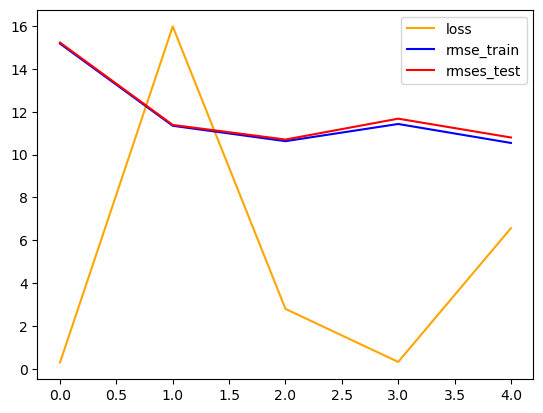

In [126]:
plt.plot(losses, color="orange")
plt.plot(rmses, color="blue")
plt.plot(rmses_test, color="red")
plt.legend(["loss", "rmse_train", "rmses_test"])

In [74]:
new_model = nn.Sequential(*list(model.children())[:-1])
new_model.add_module('identity', nn.Identity())
new_model

class RandomForestClassifierWrapper:
    def __init__(self, n_estimators=1000, max_depth=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)

    def train(self, X_train, y_train):
        X_train = X_train.detach().numpy()
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        X_test = X_test.detach().numpy()
        return self.model.predict(X_test)

new_model.eval()
x_train = x_train.to(device=device, dtype=torch.float)
x_train_bis = new_model(x_train)

random_forest = RandomForestClassifierWrapper()
random_forest.train(x_train_bis, y_train)

Sequential(
  (0): Linear(in_features=87, out_features=128, bias=True)
  (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.4, inplace=False)
  (8): Linear(in_features=128, out_features=256, bias=True)
  (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (identity): Identity()
)

val for training

In [127]:
x_val = pd.read_csv('processed_waiting_times_val.csv')
dates = x_val["DATETIME"]
entities = x_val["ENTITY_DESCRIPTION_SHORT"]
x_val.drop(["DATETIME", "ENTITY_DESCRIPTION_SHORT"], axis=1, inplace=True)

x_val = x_val.astype(float)
x_val = torch.tensor(x_val.values, dtype=torch.float64, device=device)
x_val = x_val.to(device=device, dtype=torch.float)

y_hat = torch.argmax(model(x_val), dim=1)
clean_y_hat = np.array((y_hat).cpu())*5
res_df = pd.DataFrame(list(zip(clean_y_hat, entities, dates, ["Validation" for _ in range(len(dates))])), columns=["y_pred", "ENTITY_DESCRIPTION_SHORT", "DATETIME", "KEY"])

res_df.to_csv('res.csv', index=False)

val for random forest

In [76]:
x_val = pd.read_csv('processed_waiting_times_val.csv')
dates = x_val["DATETIME"]
entities = x_val["ENTITY_DESCRIPTION_SHORT"]
x_val.drop(["DATETIME", "ENTITY_DESCRIPTION_SHORT"], axis=1, inplace=True)

x_val = x_val.astype(float)
x_val = torch.tensor(x_val.values, dtype=torch.float64, device=device)
x_val = x_val.to(device=device, dtype=torch.float)

y_hat = torch.tensor(random_forest.predict(new_model(x_val)))
clean_y_hat = np.array((y_hat).cpu())*5
res_df = pd.DataFrame(list(zip(clean_y_hat, entities, dates, ["Validation" for _ in range(len(dates))])), columns=["y_pred", "ENTITY_DESCRIPTION_SHORT", "DATETIME", "KEY"])

res_df.to_csv('res.csv', index=False)

accuracy vs lr

Epoch [1/5] -  Loss: 3.4709 - Rmse: 82.5171
	 	 	  test rmse: 83.2219
Epoch [2/5] -  Loss: 3.5032 - Rmse: 80.4270
	 	 	  test rmse: 80.9883
Epoch [3/5] -  Loss: 3.4751 - Rmse: 78.2548
	 	 	  test rmse: 78.4266
Epoch [4/5] -  Loss: 3.3968 - Rmse: 75.8028
	 	 	  test rmse: 75.7078
Epoch [5/5] -  Loss: 3.3211 - Rmse: 73.2134
	 	 	  test rmse: 72.9911
lr 1e-05 / rmse 72.99108123779297
Epoch [1/5] -  Loss: 3.6458 - Rmse: 69.7326
	 	 	  test rmse: 70.2717
Epoch [2/5] -  Loss: 3.3199 - Rmse: 55.9890
	 	 	  test rmse: 56.9167
Epoch [3/5] -  Loss: 3.2011 - Rmse: 30.5287
	 	 	  test rmse: 30.7865
Epoch [4/5] -  Loss: 2.9331 - Rmse: 17.6470
	 	 	  test rmse: 17.4804
Epoch [5/5] -  Loss: 2.6198 - Rmse: 15.7544
	 	 	  test rmse: 15.7447
lr 0.0001 / rmse 15.744726181030273
Epoch [1/5] -  Loss: 2.7499 - Rmse: 15.7777
	 	 	  test rmse: 15.7831
Epoch [2/5] -  Loss: 2.2366 - Rmse: 13.2851
	 	 	  test rmse: 13.1777
Epoch [3/5] -  Loss: 2.2461 - Rmse: 12.6135
	 	 	  test rmse: 12.5095
Epoch [4/5] -  Loss:

/var/folders/n9/pd4m7bps7_b_427s0yfq1m600000gn/T/ipykernel_46808/3552250896.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


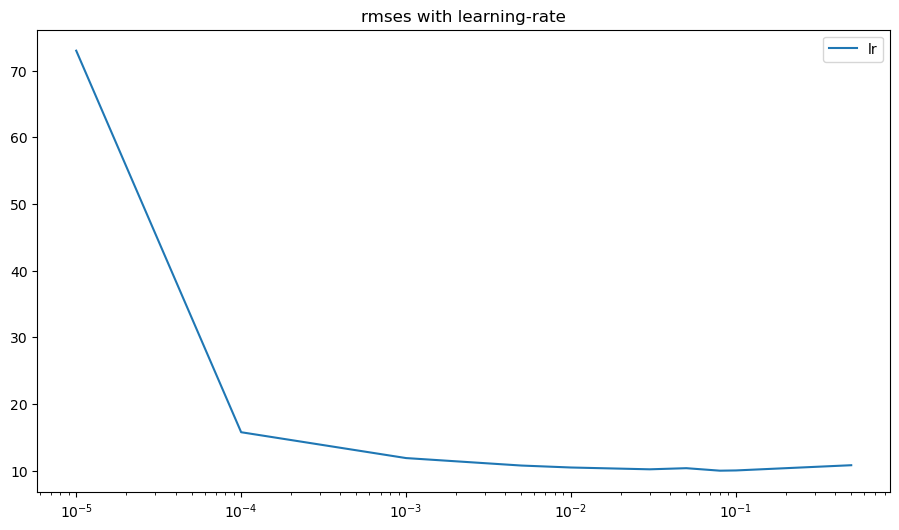

In [17]:
lrs = [1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 8e-2, 1e-1, 5e-1]
rmses = []

for lr in lrs:
  model = nn.Sequential(
    nn.Linear(in_features, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(64, out_features),
  )
  optimizer = optim.SGD(model.parameters(), momentum=0.8, lr=lr, nesterov=True)
  criterion = nn.CrossEntropyLoss()
  _, _, rmses_test = train_module(model, optimizer, x_train, y_train, check_rmse , 5, 128, True, x_test, y_test)
  rmse = rmses_test[-1]
  rmses.append(rmse)
  print(f"lr {lr} / rmse {rmse}")

fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(lrs, rmses, label='lr')
ax.set_xscale('log')
ax.legend()
ax.set_title("rmses with learning-rate")
fig.show()

#VALIDATION

In [68]:
x_val = pd.read_csv('processed_waiting_times_val.csv')
dates = x_val["DATETIME"]
entities = x_val["ENTITY_DESCRIPTION_SHORT"]
x_val.drop(["DATETIME", "ENTITY_DESCRIPTION_SHORT"], axis=1, inplace=True)

x_val = x_val.astype(float)
x_val = torch.tensor(x_val.values, dtype=torch.float64, device=device)
x_val = x_val.to(device=device, dtype=torch.float)

In [75]:
y_hat = torch.argmax(model(x_val), dim=1)

clean_y_hat = np.array((y_hat).cpu())*5

res_df = pd.DataFrame(list(zip(clean_y_hat, entities, dates, ["Validation" for _ in range(len(dates))])), columns=["y_pred", "ENTITY_DESCRIPTION_SHORT", "DATETIME", "KEY"])
#on gdrive
#res_df.to_csv('/content/gdrive/MyDrive/HACKATHON/res.csv', index=False)

#on pc
res_df.to_csv('res.csv', index=False)

autre idée

In [42]:
model = nn.Sequential(
    nn.Linear(in_features, 84),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(84, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),  # Utiliser une seule sortie pour la prédiction continue
)
model.to(device=device)
optimizer = optim.Adam(model.parameters(), lr=5e-2, weight_decay=1e-5, amsgrad=True)
criterion = nn.MSELoss()

num_epochs = 100

y_train_for_regression = y_train.float()
y_test_for_regression = y_test.float()

losses, rmses, rmses_test = train_module(model, optimizer, criterion, x_train, y_train_for_regression, check_rmse_numeric ,num_epochs, 128, True, x_test, y_test_for_regression)

/Users/emilienprn/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/emilienprn/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([46])) that is different to the input size (torch.Size([46, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100] -  Loss: 8.6606 - Rmse: 2467.8269
	 	 	  test rmse: 1211.9821
Epoch [2/100] -  Loss: 6.4383 - Rmse: 2478.7839
	 	 	  test rmse: 1217.9930
Epoch [3/100] -  Loss: 7.6820 - Rmse: 2468.6362
	 	 	  test rmse: 1212.4597
Epoch [4/100] -  Loss: 7.3392 - Rmse: 2487.2737
	 	 	  test rmse: 1222.5292
Epoch [5/100] -  Loss: 6.1603 - Rmse: 2473.4092
	 	 	  test rmse: 1214.1299
Epoch [6/100] -  Loss: 5.3400 - Rmse: 2466.6013
	 	 	  test rmse: 1211.1246
Epoch [7/100] -  Loss: 9.1840 - Rmse: 2469.5830
	 	 	  test rmse: 1212.3468
Epoch [8/100] -  Loss: 7.5108 - Rmse: 2477.8362
	 	 	  test rmse: 1217.5066
Epoch [9/100] -  Loss: 6.1294 - Rmse: 2469.1794
	 	 	  test rmse: 1212.7722
Epoch [10/100] -  Loss: 7.5877 - Rmse: 2467.6682
	 	 	  test rmse: 1211.5011
Epoch [11/100] -  Loss: 7.1297 - Rmse: 2469.1157
	 	 	  test rmse: 1212.7366
Epoch [12/100] -  Loss: 10.6246 - Rmse: 2467.2034
	 	 	  test rmse: 1211.3129
Epoch [13/100] -  Loss: 12.5342 - Rmse: 2467.3518
	 	 	  test rmse: 1211.3716
Epoch 

KeyboardInterrupt: 